# Kreditkartenbetrugserkennung mit Generative Adversarial Networks (GANs)

Dieses Projekt zielt darauf ab, Kreditkartenbetrug mithilfe von Generative Adversarial Networks (GANs) zu erkennen. Ein GAN besteht aus zwei neuronalen Netzen: einem Generator, der versucht, gefälschte (synthetische) Transaktionsdaten zu erstellen, und einem Diskriminator, der zwischen echten und gefälschten Transaktionen unterscheidet. Nach dem Training verwenden wir dieses GAN, um Anomalien in den Transaktionen zu identifizieren, was auf potenziellen Kreditkartenbetrug hinweisen könnte.

Ziel des Projekts:
- Erstellen eines GANs zur Generierung von Transaktionsdaten.
- Erkennung von Anomalien in Transaktionsdaten durch den Vergleich von echten und generierten Daten.


In [51]:
import sqlite3
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

## 1. Laden des Datensatzes und Speichern in einer SQLite-Datenbank

In diesem Schritt wird der Datensatz geladen und zur weiteren Verarbeitung in eine SQLite-Datenbank gespeichert. Dies erleichtert das Abrufen spezifischer Daten (Transaktionen und Labels) für die spätere Verarbeitung und Modellierung.


In [27]:
# Load the CSV file containing the credit card transaction data
file_path = '/content/drive/MyDrive/projects/creditcard.csv' # file_path = 'creditcard.csv' - Modify the path if necessary
df = pd.read_csv(file_path)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [28]:
# Establish a connection to the SQLite database (will be created if it does not exist)
conn = sqlite3.connect('transactions.db')


In [29]:
cursor = conn.cursor()

# Write the DataFrame into the SQL table
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Check if the data is stored correctly by fetching a sample
cursor.execute("SELECT * FROM transactions LIMIT 5")
rows = cursor.fetchall()

# Print the first 5 rows of the database
for row in rows:
    print(row)

(0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62, 0)
(0.0, 1.19185711131486, 0.26615071205963, 0.16648011335321, 0.448154078460911, 0.0600176492822243, -0.0823608088155687, -0.0788029833323113, 0.0851016549148104, -0.255425128109186, -0.166974414004614, 1.61272666105479, 1.06523531137287, 0.48909501589608, -0.143772296441519, 0.635558093258208, 0.463917041022171, -0.114804663102346, -0.183361270123994, -0.145783041325259, -0.0690831352230203, -0.225775248033138, -0.638671952771851, 0.10

## 2. Abrufen der Transaktionsdaten und Labels

Hier werden die Transaktionsdaten ohne das "Class"-Label sowie die "Class"-Labels (Betrug/Nicht-Betrug) aus der Datenbank abgefragt. Diese Daten werden für das Training und die Anomalieerkennung verwendet.

In [30]:
# Retrieve transaction data without the "Class" label (fraud/no-fraud)
query = "SELECT Time, Amount, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28 FROM transactions"
df_transactions = pd.read_sql_query(query, conn)

# Retrieve the "Class" labels (fraud/not-fraud)
df_labels = pd.read_sql_query("SELECT Class FROM transactions", conn)


print(df_transactions.head())
print(df_labels.head())

   Time  Amount        V1        V2        V3        V4        V5        V6  \
0   0.0  149.62 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1   0.0    2.69  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2   1.0  378.66 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3   1.0  123.50 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4   2.0   69.99 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8  ...       V19       V20       V21       V22       V23  \
0  0.239599  0.098698  ...  0.403993  0.251412 -0.018307  0.277838 -0.110474   
1 -0.078803  0.085102  ... -0.145783 -0.069083 -0.225775 -0.638672  0.101288   
2  0.791461  0.247676  ... -2.261857  0.524980  0.247998  0.771679  0.909412   
3  0.237609  0.377436  ... -1.232622 -0.208038 -0.108300  0.005274 -0.190321   
4  0.592941 -0.270533  ...  0.803487  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27   

## 3. Untersuchung der Verteilung von Betrugs- und Nicht-Betrugsfällen

Da Betrugsfälle selten sind, wird die Verteilung der "Class"-Labels untersucht, um ein Verständnis dafür zu gewinnen, wie stark die Daten unausgeglichen sind.


In [31]:
# Check the distribution of fraud/no-fraud labels
label_counts = df['Class'].value_counts()
print(label_counts)

Class
0    284315
1       492
Name: count, dtype: int64


## 4. Normalisierung der Transaktionsdaten

Um sicherzustellen, dass alle Merkmale auf einer ähnlichen Skala liegen, wird die StandardScaler-Methode verwendet. Diese Normalisierung verbessert die Leistung des GANs.


In [32]:
# Normalize the transaction data to bring the features to a similar scale

scaler = StandardScaler()
normalized_transactions = scaler.fit_transform(df_transactions)

print(normalized_transactions[:5])

[[-1.99658302  0.24496426 -0.69424232 -0.04407492  1.6727735   0.97336551
  -0.24511658  0.34706795  0.19367894  0.08263728  0.33112778  0.08338555
  -0.54040704 -0.61829572 -0.99609892 -0.32461019  1.60401384 -0.53683287
   0.24486345  0.03076993  0.49628203  0.32611802 -0.02492336  0.38285444
  -0.17691133  0.11050692  0.24658544 -0.39217043  0.33089162 -0.06378115]
 [-1.99658302 -0.34247454  0.60849633  0.16117592  0.1097971   0.31652293
   0.04348335 -0.06181997 -0.06370021  0.07125348 -0.23249419 -0.15334963
   1.58000285  1.06608857  0.4914182  -0.14998248  0.69436042  0.52943375
  -0.13516997 -0.21876258 -0.17908605 -0.08961086 -0.3073768  -0.88007675
   0.16220118 -0.56113055  0.3206939   0.26106948 -0.02225568  0.04460752]
 [-1.99656197  1.16068593 -0.69350046 -0.81157783  1.16946849  0.26823129
  -0.36457179  1.35145359  0.63977564  0.20737273 -1.37867535  0.19069961
   0.61182971  0.06613662  0.72069985 -0.17311389  2.56290618 -3.29823537
   1.30686788 -0.14478999 -2.7785608

## 5. Aufbau des GANs: Generator und Diskriminator

Das GAN besteht aus zwei Teilen:
- Der **Generator** erzeugt synthetische Daten, die echten Transaktionen ähneln sollen.
- Der **Diskriminator** bewertet die Eingabedaten und versucht zu unterscheiden, ob sie echt oder vom Generator erzeugt wurden.


In [65]:
# Generator model definition
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh() # Output is in the range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Discriminator model definition
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2), # Leaky ReLU activation for better gradient flow
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output is in the range [0, 1]
        )

    def forward(self, x):
        return self.model(x)

# Initialize the models
input_dim = 100  # Latent space dimension for the generator (noise)
output_dim = normalized_transactions.shape[1]  # Dimension of the transaction data
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

## 6. Definition der Verlustfunktionen und Optimierer

Die Verlustfunktionen steuern die Lernprozesse von Generator und Diskriminator. BCELoss (Binary Cross-Entropy Loss) wird verwendet, um die Wahrscheinlichkeiten zu bewerten, ob eine Transaktion echt oder gefälscht ist. Der Adam-Optimierer wird für das Gradienten-Update verwendet.


In [ ]:
# Define loss and optimization functions
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for both generator and discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

## 7. Training des GANs

Das GAN wird über mehrere Epochen trainiert. Zuerst wird der Diskriminator trainiert, um zwischen echten und generierten Daten zu unterscheiden. Anschließend wird der Generator trainiert, um den Diskriminator zu täuschen, indem er bessere gefälschte Daten generiert.


In [66]:
# Function to generate random noise
def generate_noise(batch_size, input_dim):
    return torch.randn(batch_size, input_dim)

# Training des GANs
num_epochs = 30000 # Set the number of epochs for training
batch_size = 128 # Set the batch size for each training step

# Lists to store loss values for both discriminator and generator
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    # 1. Discriminator training: Train on both real and fake data
    real_data = torch.tensor(normalized_transactions[np.random.randint(0, normalized_transactions.shape[0], batch_size)], dtype=torch.float)
    fake_data = generator(generate_noise(batch_size, input_dim)).detach() # Generate fake data and detach to avoid backpropagation to generator

    # Discriminator loss for real data
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1)) # Real data labeled as 1
    fake_loss = criterion(discriminator(fake_data), torch.zeros(batch_size, 1)) # Fake data labeled as 0
    d_loss = real_loss + fake_loss

    # Backpropagation for discriminator
    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()

    # 2. Generator training: Train to fool the discriminator
    noise = generate_noise(batch_size, input_dim)
    generated_data = generator(noise)

    # Generator loss: Try to make the discriminator classify generated data as real (1)
    g_loss = criterion(discriminator(generated_data), torch.ones(batch_size, 1))

    # Backpropagation for generator
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    # Append loss values to the lists
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    # Print progress every 500 epochs
    if epoch % 500 == 0 or epoch == 29999:
        print(f'Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}')

Epoch [0/30000] | D Loss: 1.3920226097106934 | G Loss: 0.6355958580970764
Epoch [500/30000] | D Loss: 1.289509654045105 | G Loss: 0.6069989204406738
Epoch [1000/30000] | D Loss: 1.2316555976867676 | G Loss: 0.6212378740310669
Epoch [1500/30000] | D Loss: 1.2880018949508667 | G Loss: 0.5925658345222473
Epoch [2000/30000] | D Loss: 1.218121886253357 | G Loss: 0.649676501750946
Epoch [2500/30000] | D Loss: 1.167553186416626 | G Loss: 0.7036561369895935
Epoch [3000/30000] | D Loss: 1.2301735877990723 | G Loss: 0.7069275975227356
Epoch [3500/30000] | D Loss: 1.1036264896392822 | G Loss: 0.8965789079666138
Epoch [4000/30000] | D Loss: 1.2489417791366577 | G Loss: 0.6845990419387817
Epoch [4500/30000] | D Loss: 1.0973484516143799 | G Loss: 0.8241296410560608
Epoch [5000/30000] | D Loss: 1.2566989660263062 | G Loss: 0.6965122222900391
Epoch [5500/30000] | D Loss: 1.0812581777572632 | G Loss: 0.8376065492630005
Epoch [6000/30000] | D Loss: 1.045893907546997 | G Loss: 0.913982093334198
Epoch [65

Die Performance dieses Modells mit 30.000 Epochen ist sehr stabil. Der Generator lernt kontinuierlich, bessere Daten zu erzeugen, und der Diskriminator hat eine gute Fähigkeit, diese zu unterscheiden. Die Verluste zeigen keine extremen Schwankungen, was darauf hinweist, dass das Training gut gesteuert wurde.

## 8. Visualisierung der Verluste

Die Verluste des Diskriminators und Generators werden über die Epochen hinweg aufgezeichnet und visualisiert, um den Fortschritt des Trainings zu verfolgen.


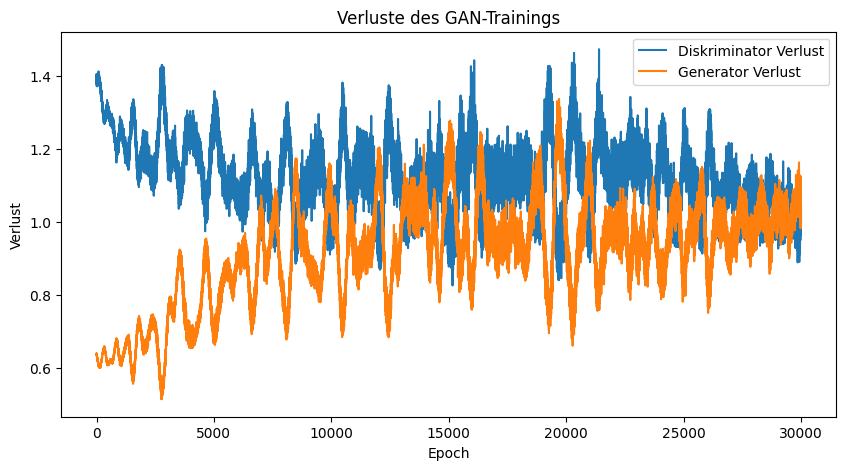

In [67]:
# Plot discriminator and generator losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 9. Generierung neuer Transaktionen

Nach dem Training des GANs können wir synthetische Transaktionen generieren. Diese werden mit den echten Transaktionen verglichen, um Anomalien zu identifizieren.


In [76]:
# Generate new transactions
generated_transactions = generator(generate_noise(normalized_transactions.shape[0], input_dim)).detach().numpy()

# Compare real and generated transactions by calculating the absolute differences
differences = np.mean(np.abs(normalized_transactions - generated_transactions), axis=1)

# Set a threshold for anomalies (Top 5% as anomalies)
threshold = np.percentile(differences, 95)  # Top 5% of differences are considered anomalies
anomalies = differences > threshold

# Print the number of detected anomalies
print(f'Number of detected anomalies: {np.sum(anomalies)}')

# Now, check which anomalies correspond to actual fraud (Class == 1)
# We need to filter the rows in the original dataset where anomalies are detected and the 'Class' is 1
actual_fraud_anomalies = df_labels[anomalies].values.flatten() == 1

# Print the number of anomalies that correspond to actual fraud
print(f'Number of detected anomalies that are actual fraud: {np.sum(actual_fraud_anomalies)}')

Number of detected anomalies: 14241
Number of detected anomalies that are actual fraud: 411


# Zusammenfassung

In diesem Projekt haben wir ein Generative Adversarial Network (GAN) entwickelt, um Kreditkartenbetrug zu erkennen. Durch das Training des GANs haben wir synthetische Transaktionen erzeugt und Anomalien in den echten Transaktionen identifiziert. Diese Anomalien könnten auf potenziellen Betrug hinweisen. Der Einsatz von GANs zur Generierung von synthetischen Daten ermöglicht eine verbesserte Anomalieerkennung in unscharfen und unausgewogenen Datensätzen wie denen, die für die Betrugserkennung verwendet werden.
